In [143]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

import os

In [263]:
cwd = os.getcwd()
fp = os.path.join(cwd,'data/HCP500_rfMRI_motion.txt')
hcp=np.loadtxt(fp)
fp = os.path.join(cwd,'data/mean_FDs.txt')
abcd=np.loadtxt(fp)

print(len(abcd))

# for ABCD, if nan (meaning they had no remaining timepoints, so drop them)
abcd = abcd[~np.isnan(abcd)]
print(len(abcd))

<class 'numpy.ndarray'>
8814
8811


In [264]:
def plot_hist(l1,l2,titlestr):
    bins=50
    fig, ax = plt.subplots()

    # Call the sns.set() function 
    sns.set()
    sns.distplot(l1,bins=bins,norm_hist=True,label='hcp',fit=stats.gamma,kde=False,color=sns.xkcd_rgb["pale red"])
    sns.distplot(l2,bins=bins,norm_hist=True,label='abcd',fit=stats.gamma,kde=False,color=sns.xkcd_rgb["denim blue"])

    # plt.axvline(np.median(hcp), linestyle='--',color=sns.xkcd_rgb["pale red"])
    # plt.axvline(np.median(abcd), linestyle='--',color=sns.xkcd_rgb["denim blue"])

    plt.legend(loc='upper right', bbox_to_anchor=(0.95, 0.99),fontsize=12)

    ax.set_xlabel('Frame displacement (mm)')
    ax.set_ylabel('Probability density')
    ax.set_title(titlestr)

    textstr1 = '\n'.join((
        r'$n=%d$' % (len(l1), ),
        r'$\mu=%.4f$' % (np.mean(l1), ),
        r'$\mathrm{median}=%.4f$' % (np.median(l1), ),
        r'$\sigma=%.4f$' % (np.std(l1), )))

    textstr2 = '\n'.join((
        r'$n=%d$' % (len(l2), ),
        r'$\mu=%.4f$' % (np.mean(l2), ),
        r'$\mathrm{median}=%.4f$' % (np.median(l2), ),
        r'$\sigma=%.4f$' % (np.std(l2), )))

    props1 = dict(boxstyle='round', facecolor=sns.xkcd_rgb["pale red"], alpha=0.5)
    props2 = dict(boxstyle='round', facecolor=sns.xkcd_rgb["denim blue"], alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(0.95, 0.7, textstr1, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right', bbox=props1)
    # place a text box in upper left in axes coords
    ax.text(0.95, 0.4, textstr2, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', horizontalalignment='right', bbox=props2)

    # Tweak spacing to prevent clipping of ylabel
    fig.tight_layout()
    plt.show()
    # fig.savefig(os.path.join(cwd,'data/hcp_abcd_histogram_2.png'),dpi=600)

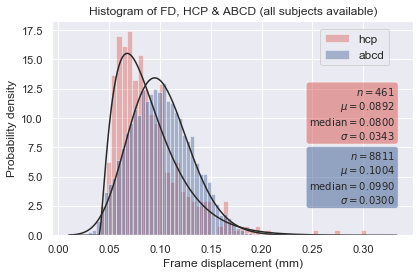

In [266]:
plot_hist(hcp,abcd,'Histogram of FD, HCP & ABCD (all subjects available)')

In [146]:
stats.ks_2samp(hcp, abcd)

Ks_2sampResult(statistic=0.23511751111741364, pvalue=1.8462861366107304e-21)

In [147]:
# The above statistical test concludes that the distributions ARE DIFFERENT --> we cannot use all subjects from each.
# The above distribution was drawn with ALL ABCD subjects with available timeseries, regardless of how much "good" scan time they have. We will be using >10min scan time as the cutoff.

In [148]:
# Lets find out how many subjects have >10min scan time.
fp = os.path.join(cwd,'data/motion_summary_data.csv')

dtype_dict={
    'sub': 'O',
    'total_frame_count': 'int32',
    'remaining_frame_count': 'UInt32',
    'remaining_seconds': 'f8',
    'remaining_frame_mean_FD': 'f8'
}

# note that msd means 'motion_summary_data'
msd = pd.read_csv(fp, sep=',')

# again, drop subjects w/ nan in their remaining_frame_mean_FD
msd=msd[~np.isnan(msd['remaining_frame_mean_FD'])] #replace nan w/ )
msd.shape

(8811, 5)

In [149]:
print(len(msd[msd['remaining_seconds'].ge(600)]))
print(len(msd['sub']))
print(len(msd[(msd['remaining_seconds']>600)])/len(msd['sub']))

7215
8811
0.8179548291907842


In [150]:
# This is a pretty good sample size, compared to original of 8811 (81%)

In [261]:
# Now, lets recreate the histograms for analysis
# msd_rt_filt means "motion_summary_data_remaining_time_filtered" 
msd_rt_filt=msd[(msd['remaining_seconds']>=600)]
abcd = msd_rt_filt['remaining_frame_mean_FD'].tolist()
# msd_rt_filt

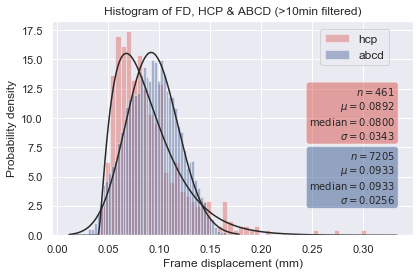

In [259]:
plot_hist(hcp,abcd,'Histogram of FD, HCP & ABCD (>10min filtered)')

In [163]:

stats.ks_2samp(hcp, abcd)

Ks_2sampResult(statistic=0.18538865914137065, pvalue=2.3202708814419377e-13)

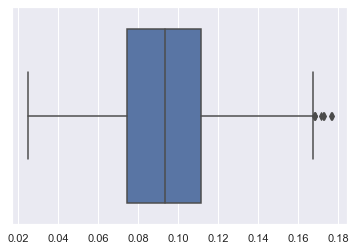

In [164]:
# Visualize outliers
sns.boxplot(x=abcd)

In [165]:
# Finally, lets remove the 3 outliers seen in the boxplot
# Function to Detection Outlier on one-dimentional datasets.
anomalies=[]
def find_anomalies(random_data):
    cutoff = 2.80703    # z score corresponds to top and bottom 0.25% of data
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(random_data)
    random_data_mean = np.mean(random_data)
    anomaly_cut_off = random_data_std * cutoff
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    # print(lower_limit)
    # Generate outliers
    for outlier in random_data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

In [258]:
anoms=find_anomalies(abcd)

In [257]:
# Alternatively, we can cut off the top and bottom 0.25% of subjects (as recommended in the ABCD 2.0.1 documentation)
# Now, let's plot the distribution without these outliers:
msd_rt_anom_filt = msd_rt_filt[~msd_rt_filt['remaining_frame_mean_FD'].isin(anoms)]
abcd=msd_rt_anom_filt['remaining_frame_mean_FD'].tolist()

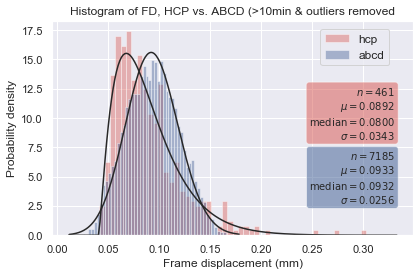

In [256]:
plot_hist(hcp,abcd,'Histogram of FD, HCP vs. ABCD (>10min & outliers removed')

In [172]:

stats.ks_2samp(hcp, abcd)

Ks_2sampResult(statistic=0.18493544342097934, pvalue=2.690174844608066e-13)

In [174]:
# Doesn't appear to make much difference when comparing the distributions, but we will drop them anyway since its only 10 subjects

In [239]:
# Now that we've removed subjects based on amount of "good" scan time & removed outliers (for n=7205), let's pull the mri QC metrics from the 2.0.1 release file (mriqcrp102.txt)
# This can be obtained via the shared package 144683,ABCDFixRelease

cwd=os.getcwd()
fp = os.path.join(cwd,'./data/mriqcrp102.txt')
mriqc = pd.read_csv(fp,sep='\t')
mriqc=mriqc.drop(mriqc.index[0])      # drop the first row (its a bunch of strings we dont need)

# Now, we need to change the format of the subject key by removing the underscore (ex. NDAR_INVX8CRJYVP	 --> NDARINVX8CRJYVP)
mriqc['subjectkey'] = mriqc['subjectkey'].str.replace('_','')

# mriqc

In [255]:
qc = mriqc[['subjectkey','iqc_t1_ok_ser','iqc_rsfmri_ok_ser']]
subs = msd_rt_anom_filt['sub'].tolist()
qc=qc[qc['subjectkey'].isin(subs)]


In [241]:
# We will exclude the 7 subjects whose data is missing from the qc file
# Now drop any rows with NaNs
qc.dropna(inplace=True)
qc.shape    #7192 subjects
# qc.isna()
# qc[(qc['iqc_t1_ok_ser'].isnull() | qc['iqc_rsfmri_ok_ser'].isnull())].index.tolist()

(7192, 3)

In [243]:
# Final processing step, apply these inclusion criteria
# 1. iqc_t1_ok_ser > 0
# 2. iqc_rsfmri_ok_ser > 2 (for 10 mins)

qc['iqc_t1_ok_ser'] = pd.to_numeric(qc['iqc_t1_ok_ser'])
qc['iqc_rsfmri_ok_ser'] = pd.to_numeric(qc['iqc_rsfmri_ok_ser'])

qc2 = qc.drop(qc[ ~( (qc['iqc_t1_ok_ser'] > 0) & (qc['iqc_rsfmri_ok_ser'] >= 2) ) ].index)
qc2.shape


(7185, 3)

In [268]:
# Our final sample size is 7185 subjects.
# Let's make one final plot of the histograms
final_subs = qc2['subjectkey'].tolist()

msd_final = msd_rt_anom_filt[msd_rt_anom_filt['sub'].isin(final_subs)]

abcd=msd_final['remaining_frame_mean_FD'].tolist()
len(abcd)

7185

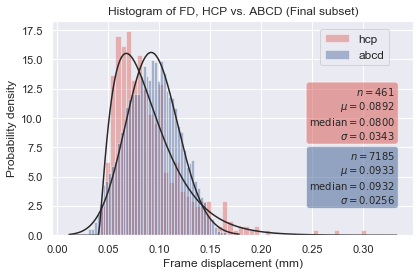

In [269]:
plot_hist(hcp,abcd,'Histogram of FD, HCP vs. ABCD (Final subset)')

In [279]:
print(type(final_subs))

<class 'list'>


In [286]:
# Output a final list of subjects to be included in the group-ICA
f1=open('data/ica_subjects.txt','w')
f2=open('../data/ica_subjects.txt','w')

for ele in final_subs:
    f1.write(ele+'\n')
    f2.write(ele+'\n')
    
f1.close()
f2.close()